In [21]:
# Step 1: Imports and Config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import seaborn as sns
import leafmap.foliumap as leafmap
from shapely.geometry import box, Point
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Step 2: Constants and Paths
data_dir = "../data"
rgb_dir = os.path.join(data_dir, "rgb")
delhi_ncr_path = os.path.join(data_dir, "delhi_ncr_region.geojson")

# ESA WorldCover Mapping (if needed later)
ESA_CLASS_MAPPING = {
    10: 'Tree cover', 20: 'Shrubland', 30: 'Grassland',
    40: 'Cropland', 50: 'Built-up', 60: 'Bare/sparse vegetation',
    70: 'Snow and ice', 80: 'Permanent water bodies',
    90: 'Herbaceous wetland', 95: 'Mangroves', 100: 'Moss and lichen'
}


In [23]:
# Step 3: Load Delhi-NCR Shapefile
delhi_ncr = gpd.read_file(delhi_ncr_path)


In [24]:
# Step 4: Reproject to UTM and Create 60x60 km Grid
ncr_utm = delhi_ncr.to_crs(epsg=32644)  # UTM zone 44N for Delhi

def create_grid(gdf, grid_size=60000):  # 60 km
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    cols = np.arange(xmin, xmax, grid_size)
    rows = np.arange(ymin, ymax, grid_size)
    boxes = [box(x, y, x+grid_size, y+grid_size) for x in cols for y in rows]
    return gpd.GeoDataFrame({'geometry': boxes}, crs=gdf.crs)

grid_utm = create_grid(ncr_utm)
grid = grid_utm.to_crs(epsg=4326)  # Back to WGS84


In [25]:
# Check CRS is UTM (meters)
print(grid_utm.crs)

# Take the first polygon (grid cell)
first_cell = grid_utm.geometry.iloc[0]

# Get bounds
minx, miny, maxx, maxy = first_cell.bounds

# Compute width and height
width = maxx - minx
height = maxy - miny

print(f"Grid cell size: {width/1000:.1f} km x {height/1000:.1f} km")


EPSG:32644
Grid cell size: 60.0 km x 60.0 km


In [26]:
image_width_m = 128 * 10  # 128 pixels × 10m
image_height_m = 128 * 10

print(f"Image size: {image_width_m/1000:.1f} km x {image_height_m/1000:.1f} km")


Image size: 1.3 km x 1.3 km


In [27]:
grid_km = 60
image_km = 1.28  # 128×10m

n_tiles = grid_km / image_km
print(f"Images per grid side: {n_tiles:.1f} → ~{int(n_tiles)}")
print(f"Total images in grid: ~{int(n_tiles) ** 2}")


Images per grid side: 46.9 → ~46
Total images in grid: ~2116


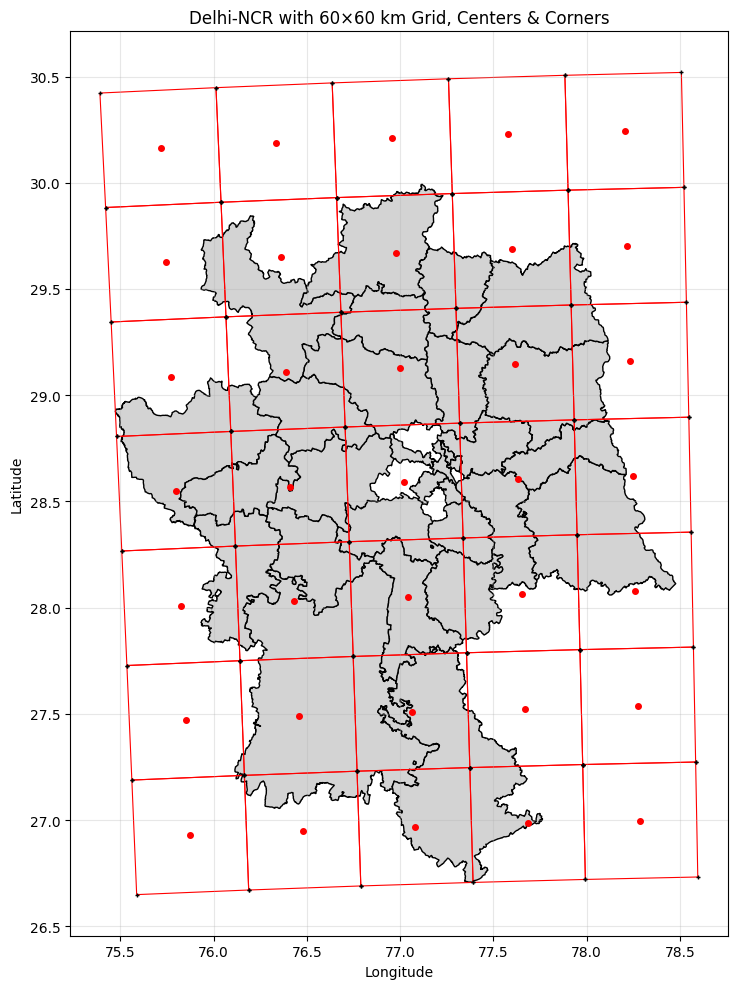

In [28]:
# ✅ Q1.1: Plot the Delhi-NCR shapefile using matplotlib and overlay the grid (1 mark)
fig, ax = plt.subplots(figsize=(12, 10))
delhi_ncr.plot(ax=ax, edgecolor='black', facecolor='lightgrey')
grid.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.8)

# ✅ Q1.3: Mark the four corners and center of each grid cell (1 mark)
centers = grid.geometry.centroid
for poly in grid.geometry:
    for x, y in list(poly.exterior.coords)[:4]:
        ax.plot(x, y, 'k+', markersize=3)
for pt in centers:
    ax.plot(pt.x, pt.y, 'ro', markersize=4)

ax.set_title("Delhi-NCR with 60×60 km Grid, Centers & Corners")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("/Users/shreyshah/Documents/earth-observation-delhi-air/scripts/q1_grid_plot.png", dpi=300)
plt.show()


In [29]:
# ✅ Q1.2: Overlay this grid on a satellite basemap using geemap or leafmap (1 mark)
m = leafmap.Map(center=[28.6, 77.2], zoom=8)
m.add_basemap("SATELLITE")
m.add_gdf(delhi_ncr, layer_name="Delhi-NCR")
m.add_gdf(grid, layer_name="Grid")

# Optional: add centers and corners to interactive map (optional for marks)
center_gdf = gpd.GeoDataFrame(geometry=centers, crs="EPSG:4326")
corner_points = []
for poly in grid.geometry:
    corner_points += [Point(x, y) for x, y in list(poly.exterior.coords)[:4]]
corner_gdf = gpd.GeoDataFrame(geometry=corner_points, crs="EPSG:4326")
m.add_gdf(center_gdf, layer_name="Grid Centers", color="red")
m.add_gdf(corner_gdf, layer_name="Grid Corners", color="black")

m  # Display interactive map


In [30]:
# ✅ Q1.4: Filter images based on center coordinates falling within the grid (1 mark)

# Example filename: 77.1025_28.7041.png (lon_lat format)
image_files = [f for f in os.listdir(rgb_dir) if f.endswith('.png')]
coords = []
for f in image_files:
    try:
        lat, lon = map(float, f.replace(".png", "").split("_"))  # assuming lon_lat
        coords.append((lat, lon, f))
    except Exception as e:
        print(f"Skipping file: {f} | Error: {e}")

# Convert to GeoDataFrame
df = pd.DataFrame(coords, columns=["lat", "lon", "filename"])
gdf_images = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")

# Spatial join to keep only points inside the grid
filtered = gpd.sjoin(gdf_images, grid, predicate="within", how="inner")


In [31]:
# ✅ Q1.5: Count and report number of images before and after filtering (1 mark)
print(f"Total images before filtering: {len(df)}")
print(f"Total images after filtering: {len(filtered)}")

# Save filtered list
filtered.to_csv("filtered_images.csv", index=False)


Total images before filtering: 9216
Total images after filtering: 9216


In [32]:
import rasterio
from collections import Counter

landcover_path = os.path.join(data_dir, 'worldcover_bbox_delhi_ncr_2021.tif')
patch_size = 128
half_patch = patch_size // 2

with rasterio.open(landcover_path) as src:
    landcover_data = src.read(1)
    transform = src.transform
    crs = src.crs

    labels = []
    filenames = []
    for lat, lon, filename in coords:
        try:
            row, col = rasterio.transform.rowcol(transform, lon, lat)
            row_start = max(0, row - half_patch)
            row_end = min(landcover_data.shape[0], row + half_patch)
            col_start = max(0, col - half_patch)
            col_end = min(landcover_data.shape[1], col + half_patch)

            patch = landcover_data[row_start:row_end, col_start:col_end]

            if patch.shape[0] < 128 or patch.shape[1] < 128:
                continue  # skip edge cases

            valid_pixels = patch[patch != 0]  # assuming 0 is no-data
            if len(valid_pixels) == 0:
                continue  # skip if no valid pixels

            mode_class = Counter(valid_pixels.flatten()).most_common(1)[0][0]
            label = ESA_CLASS_MAPPING.get(mode_class)
            if label:
                labels.append(label)
                filenames.append(filename)

        except Exception as e:
            print(f"Error processing {filename}: {e}")


In [33]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame({'filename': filenames, 'label': labels})
train_df, test_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)


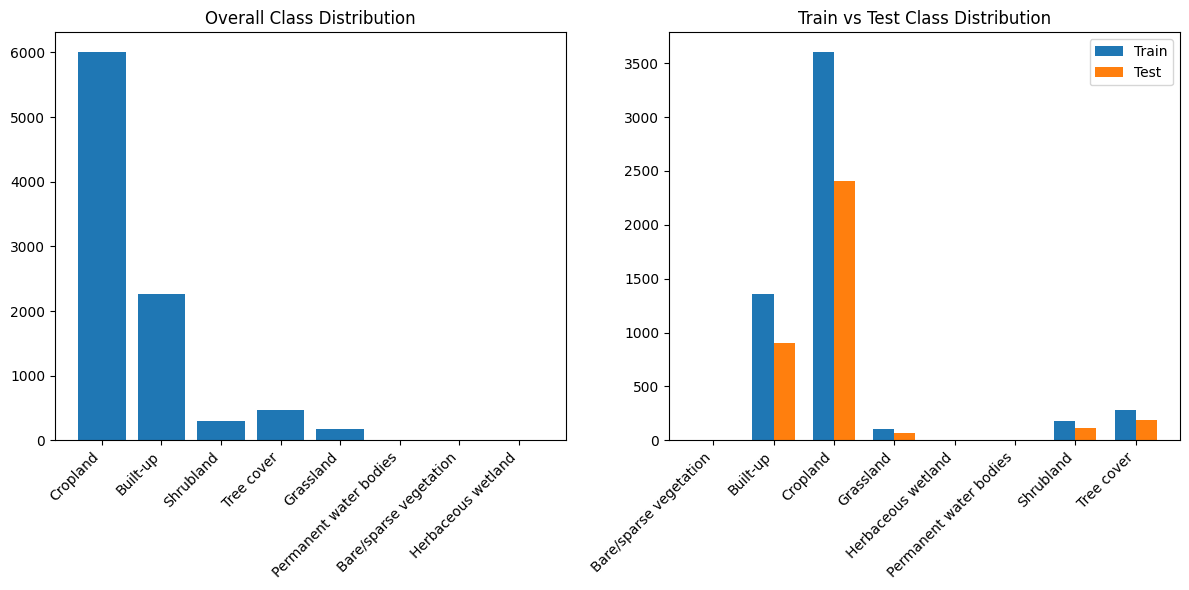

In [34]:
import matplotlib.pyplot as plt
from collections import Counter

plt.figure(figsize=(12, 6))

# Full dataset
plt.subplot(1, 2, 1)
label_counts = Counter(labels)
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title("Overall Class Distribution")

# Train vs Test
train_counts = Counter(train_df['label'])
test_counts = Counter(test_df['label'])
classes = sorted(set(labels))
x = np.arange(len(classes))
width = 0.35

plt.subplot(1, 2, 2)
plt.bar(x - width/2, [train_counts.get(c, 0) for c in classes], width, label='Train')
plt.bar(x + width/2, [test_counts.get(c, 0) for c in classes], width, label='Test')
plt.xticks(x, classes, rotation=45, ha='right')
plt.title("Train vs Test Class Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("q2_class_distribution.png", dpi=300)
plt.show()


In [35]:
import os
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet
                         std=[0.229, 0.224, 0.225])
])

In [36]:
from torch.utils.data import Dataset, DataLoader

class SatelliteDataset(Dataset):
    def __init__(self, df, img_dir, label2idx, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        img = Image.open(img_path).convert('RGB')
        label = self.label2idx[row['label']]
        if self.transform:
            img = self.transform(img)
        return img, label


In [42]:
import torch

label2idx = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
idx2label = {v: k for k, v in label2idx.items()}

train_dataset = SatelliteDataset(train_df, rgb_dir, label2idx, transform)
test_dataset = SatelliteDataset(test_df, rgb_dir, label2idx, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [41]:
print(len(train_loader))
print(train_df.head())


173
                 filename     label
7447  28.5443_77.0322.png  Built-up
5981  28.2056_77.1058.png  Cropland
5814  28.6557_77.5821.png  Cropland
743   28.5854_77.3444.png  Built-up
6902  28.6942_76.9910.png  Cropland


Using device: cpu
Model loaded with 8 classes
Classes: ['Bare/sparse vegetation', 'Built-up', 'Cropland', 'Grassland', 'Herbaceous wetland', 'Permanent water bodies', 'Shrubland', 'Tree cover']

Starting CNN training...
Model loaded with 8 classes
Classes: ['Bare/sparse vegetation', 'Built-up', 'Cropland', 'Grassland', 'Herbaceous wetland', 'Permanent water bodies', 'Shrubland', 'Tree cover']

Starting CNN training...
Epoch 1/5, Batch 0/173, Loss: 2.4048
Epoch 1/5, Batch 0/173, Loss: 2.4048
Epoch 1/5, Batch 10/173, Loss: 0.8346
Epoch 1/5, Batch 10/173, Loss: 0.8346
Epoch 1/5, Batch 20/173, Loss: 0.5961
Epoch 1/5, Batch 20/173, Loss: 0.5961
Epoch 1/5, Batch 30/173, Loss: 0.3451
Epoch 1/5, Batch 30/173, Loss: 0.3451
Epoch 1/5, Batch 40/173, Loss: 0.4100
Epoch 1/5, Batch 40/173, Loss: 0.4100
Epoch 1/5, Batch 50/173, Loss: 0.3663
Epoch 1/5, Batch 50/173, Loss: 0.3663
Epoch 1/5, Batch 60/173, Loss: 0.1782
Epoch 1/5, Batch 60/173, Loss: 0.1782
Epoch 1/5, Batch 70/173, Loss: 0.4117
Epoch 1/5,

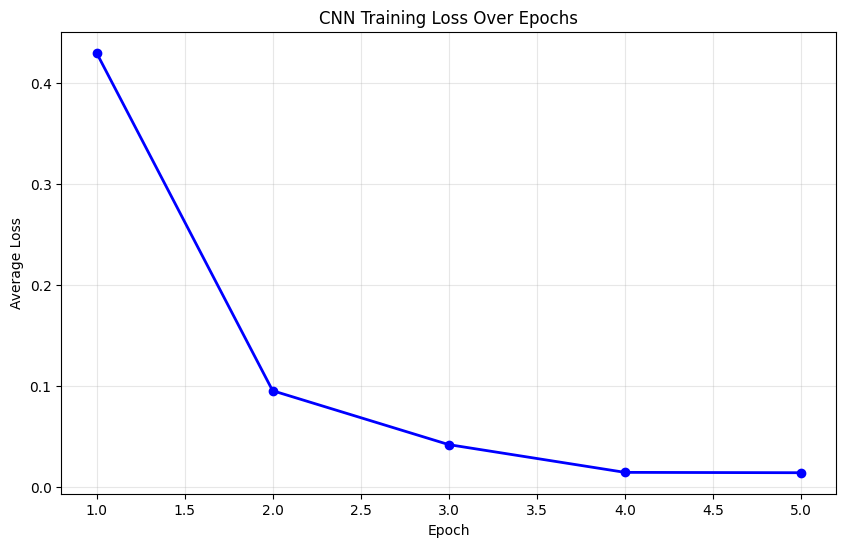

In [40]:
import torch.nn as nn
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained ResNet18 and modify for our classes
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label2idx))  # Adjust for our number of classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(f"Model loaded with {len(label2idx)} classes")
print(f"Classes: {list(label2idx.keys())}")

epochs = 5
train_losses = []

print("\nStarting CNN training...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    try:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            num_batches += 1
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        avg_loss = running_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} completed - Average Loss: {avg_loss:.4f}")
        
    except Exception as e:
        print(f"Error during training at epoch {epoch+1}: {e}")
        import traceback
        traceback.print_exc()
        break

print("CNN training completed!")

# Plot training loss curve
if train_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', linewidth=2, marker='o')
    plt.title('CNN Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

In [44]:
from sklearn.metrics import f1_score
import numpy as np
from collections import defaultdict

def custom_f1_score(y_true, y_pred, average='macro'):
    """
    Custom implementation of F1 score
    
    Args:
        y_true: True labels
        y_pred: Predicted labels  
        average: 'macro', 'micro', or 'weighted'
    
    Returns:
        F1 score
    """
    # Get unique classes
    classes = np.unique(np.concatenate([y_true, y_pred]))
    
    # Calculate per-class metrics
    class_metrics = {}
    total_tp = total_fp = total_fn = 0
    
    for cls in classes:
        # True positives, false positives, false negatives
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        # Calculate precision and recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics[cls] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': np.sum(y_true == cls)
        }
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
    
    # Calculate average F1 score
    if average == 'macro':
        return np.mean([metrics['f1'] for metrics in class_metrics.values()])
    elif average == 'micro':
        micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        return 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    elif average == 'weighted':
        total_support = sum(metrics['support'] for metrics in class_metrics.values())
        return sum(metrics['f1'] * metrics['support'] for metrics in class_metrics.values()) / total_support if total_support > 0 else 0
    
    return class_metrics

# Evaluate the trained model
print("Evaluating trained CNN model...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        
        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate custom F1 scores
macro_f1 = custom_f1_score(all_labels, all_preds, average='macro')
micro_f1 = custom_f1_score(all_labels, all_preds, average='micro')
weighted_f1 = custom_f1_score(all_labels, all_preds, average='weighted')

print(f"\n=== Custom F1 Score Results ===")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Get detailed per-class metrics
class_metrics = custom_f1_score(all_labels, all_preds, average=None)

print(f"\n=== Per-Class Metrics ===")
print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 70)

for class_idx, metrics in class_metrics.items():
    class_name = idx2label[class_idx] if class_idx in idx2label else f"Class_{class_idx}"
    print(f"{class_name:<20} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1']:<10.3f} {metrics['support']:<10}")

# Compare with sklearn implementation
from sklearn.metrics import f1_score
sklearn_macro_f1 = f1_score(all_labels, all_preds, average='macro')
sklearn_micro_f1 = f1_score(all_labels, all_preds, average='micro')
sklearn_weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n=== Comparison with sklearn ===")
print(f"Custom Macro F1: {macro_f1:.4f} | sklearn Macro F1: {sklearn_macro_f1:.4f}")
print(f"Custom Micro F1: {micro_f1:.4f} | sklearn Micro F1: {sklearn_micro_f1:.4f}")
print(f"Custom Weighted F1: {weighted_f1:.4f} | sklearn Weighted F1: {sklearn_weighted_f1:.4f}")

# Calculate overall accuracy
accuracy = np.mean(all_labels == all_preds)
print(f"\nOverall Accuracy: {accuracy:.4f}")

Evaluating trained CNN model...
Processed batch 0/116
Processed batch 0/116
Processed batch 10/116
Processed batch 10/116
Processed batch 20/116
Processed batch 20/116
Processed batch 30/116
Processed batch 30/116
Processed batch 40/116
Processed batch 40/116
Processed batch 50/116
Processed batch 50/116
Processed batch 60/116
Processed batch 60/116
Processed batch 70/116
Processed batch 70/116
Processed batch 80/116
Processed batch 80/116
Processed batch 90/116
Processed batch 90/116
Processed batch 100/116
Processed batch 100/116
Processed batch 110/116
Processed batch 110/116

=== Custom F1 Score Results ===
Macro F1 Score: 0.4763
Micro F1 Score: 0.9265
Weighted F1 Score: 0.9230

=== Per-Class Metrics ===
Class                Precision  Recall     F1-Score   Support   
----------------------------------------------------------------------
Bare/sparse vegetation 0.000      0.000      0.000      1         
Built-up             0.911      0.920      0.916      904       
Cropland      

In [45]:

try:
    import torchmetrics
    print("torchmetrics found, proceeding with evaluation...")
except ImportError:
    print("Installing torchmetrics...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchmetrics"])
    import torchmetrics

import torch

# Convert predictions and labels to tensors
preds_tensor = torch.tensor(all_preds, dtype=torch.long)
labels_tensor = torch.tensor(all_labels, dtype=torch.long)

num_classes = len(label2idx)
print(f"Number of classes: {num_classes}")

# Initialize torchmetrics F1Score with different averaging methods
f1_macro = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
f1_micro = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="micro")
f1_weighted = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="weighted")
f1_none = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="none")

# Additional metrics for comprehensive evaluation
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
precision_metric = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average="macro")
recall_metric = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average="macro")

# Calculate torchmetrics results
torchmetrics_macro_f1 = f1_macro(preds_tensor, labels_tensor).item()
torchmetrics_micro_f1 = f1_micro(preds_tensor, labels_tensor).item()
torchmetrics_weighted_f1 = f1_weighted(preds_tensor, labels_tensor).item()
torchmetrics_per_class_f1 = f1_none(preds_tensor, labels_tensor).numpy()

torchmetrics_accuracy = accuracy_metric(preds_tensor, labels_tensor).item()
torchmetrics_precision = precision_metric(preds_tensor, labels_tensor).item()
torchmetrics_recall = recall_metric(preds_tensor, labels_tensor).item()

print(f"\n=== torchmetrics Results ===")
print(f"Macro F1 Score: {torchmetrics_macro_f1:.4f}")
print(f"Micro F1 Score: {torchmetrics_micro_f1:.4f}")
print(f"Weighted F1 Score: {torchmetrics_weighted_f1:.4f}")
print(f"Accuracy: {torchmetrics_accuracy:.4f}")
print(f"Macro Precision: {torchmetrics_precision:.4f}")
print(f"Macro Recall: {torchmetrics_recall:.4f}")

print(f"\n=== Per-Class F1 Scores (torchmetrics) ===")
print(f"{'Class':<20} {'F1-Score':<10}")
print("-" * 35)
for class_idx, f1_score in enumerate(torchmetrics_per_class_f1):
    class_name = idx2label[class_idx] if class_idx in idx2label else f"Class_{class_idx}"
    print(f"{class_name:<20} {f1_score:<10.3f}")

# Comprehensive comparison of all implementations
print(f"\n=== Comprehensive Comparison ===")
print(f"{'Metric':<20} {'Custom':<12} {'sklearn':<12} {'torchmetrics':<12} {'Difference':<12}")
print("-" * 75)

# Macro F1 comparison
custom_macro = macro_f1
sklearn_macro = sklearn_macro_f1
torch_macro = torchmetrics_macro_f1
max_diff_macro = max(abs(custom_macro - sklearn_macro), abs(custom_macro - torch_macro), abs(sklearn_macro - torch_macro))
print(f"{'Macro F1':<20} {custom_macro:<12.4f} {sklearn_macro:<12.4f} {torch_macro:<12.4f} {max_diff_macro:<12.6f}")

# Micro F1 comparison
custom_micro = micro_f1
sklearn_micro = sklearn_micro_f1
torch_micro = torchmetrics_micro_f1
max_diff_micro = max(abs(custom_micro - sklearn_micro), abs(custom_micro - torch_micro), abs(sklearn_micro - torch_micro))
print(f"{'Micro F1':<20} {custom_micro:<12.4f} {sklearn_micro:<12.4f} {torch_micro:<12.4f} {max_diff_micro:<12.6f}")

# Weighted F1 comparison
custom_weighted = weighted_f1
sklearn_weighted = sklearn_weighted_f1
torch_weighted = torchmetrics_weighted_f1
max_diff_weighted = max(abs(custom_weighted - sklearn_weighted), abs(custom_weighted - torch_weighted), abs(sklearn_weighted - torch_weighted))
print(f"{'Weighted F1':<20} {custom_weighted:<12.4f} {sklearn_weighted:<12.4f} {torch_weighted:<12.4f} {max_diff_weighted:<12.6f}")

# Accuracy comparison
custom_acc = accuracy
torch_acc = torchmetrics_accuracy
acc_diff = abs(custom_acc - torch_acc)
print(f"{'Accuracy':<20} {custom_acc:<12.4f} {'N/A':<12} {torch_acc:<12.4f} {acc_diff:<12.6f}")

# Summary
print(f"\n=== Summary ===")
if max_diff_macro < 1e-4 and max_diff_micro < 1e-4 and max_diff_weighted < 1e-4:
    print("✅ All implementations agree! Maximum difference < 0.0001")
else:
    print("⚠️  Some differences found between implementations:")
    print(f"   Max Macro F1 difference: {max_diff_macro:.6f}")
    print(f"   Max Micro F1 difference: {max_diff_micro:.6f}")
    print(f"   Max Weighted F1 difference: {max_diff_weighted:.6f}")

print(f"\nBest performing metric: Macro F1 = {max(custom_macro, sklearn_macro, torch_macro):.4f}")

Installing torchmetrics...
  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/70/19/2d8db70030d3472dad5d49136770af949f5ed597df2c1a6a509dadc5d57d/torchmetrics-1.7.4-py3-none-any.whl.metadata
  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/70/19/2d8db70030d3472dad5d49136770af949f5ed597df2c1a6a509dadc5d57d/torchmetrics-1.7.4-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/1a/c1/31b3184cba7b257a4a3b5ca5b88b9204ccb7aa02fe3c992280899293ed54/lightning_utilities-0.14.3-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/1a/c1/31b3184cba7b257a4a3b5ca5b88b9204ccb7aa02fe3c992280899293ed54/lightning_utilities-0.14.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 5.8 MB/s eta 0:00:0000:0100:01
   

=== Confusion Matrix Analysis ===

A confusion matrix shows how well the model classifies each class:
- Rows represent TRUE labels (what the image actually contains)
- Columns represent PREDICTED labels (what the model predicted)
- Diagonal elements = correct predictions
- Off-diagonal elements = misclassifications


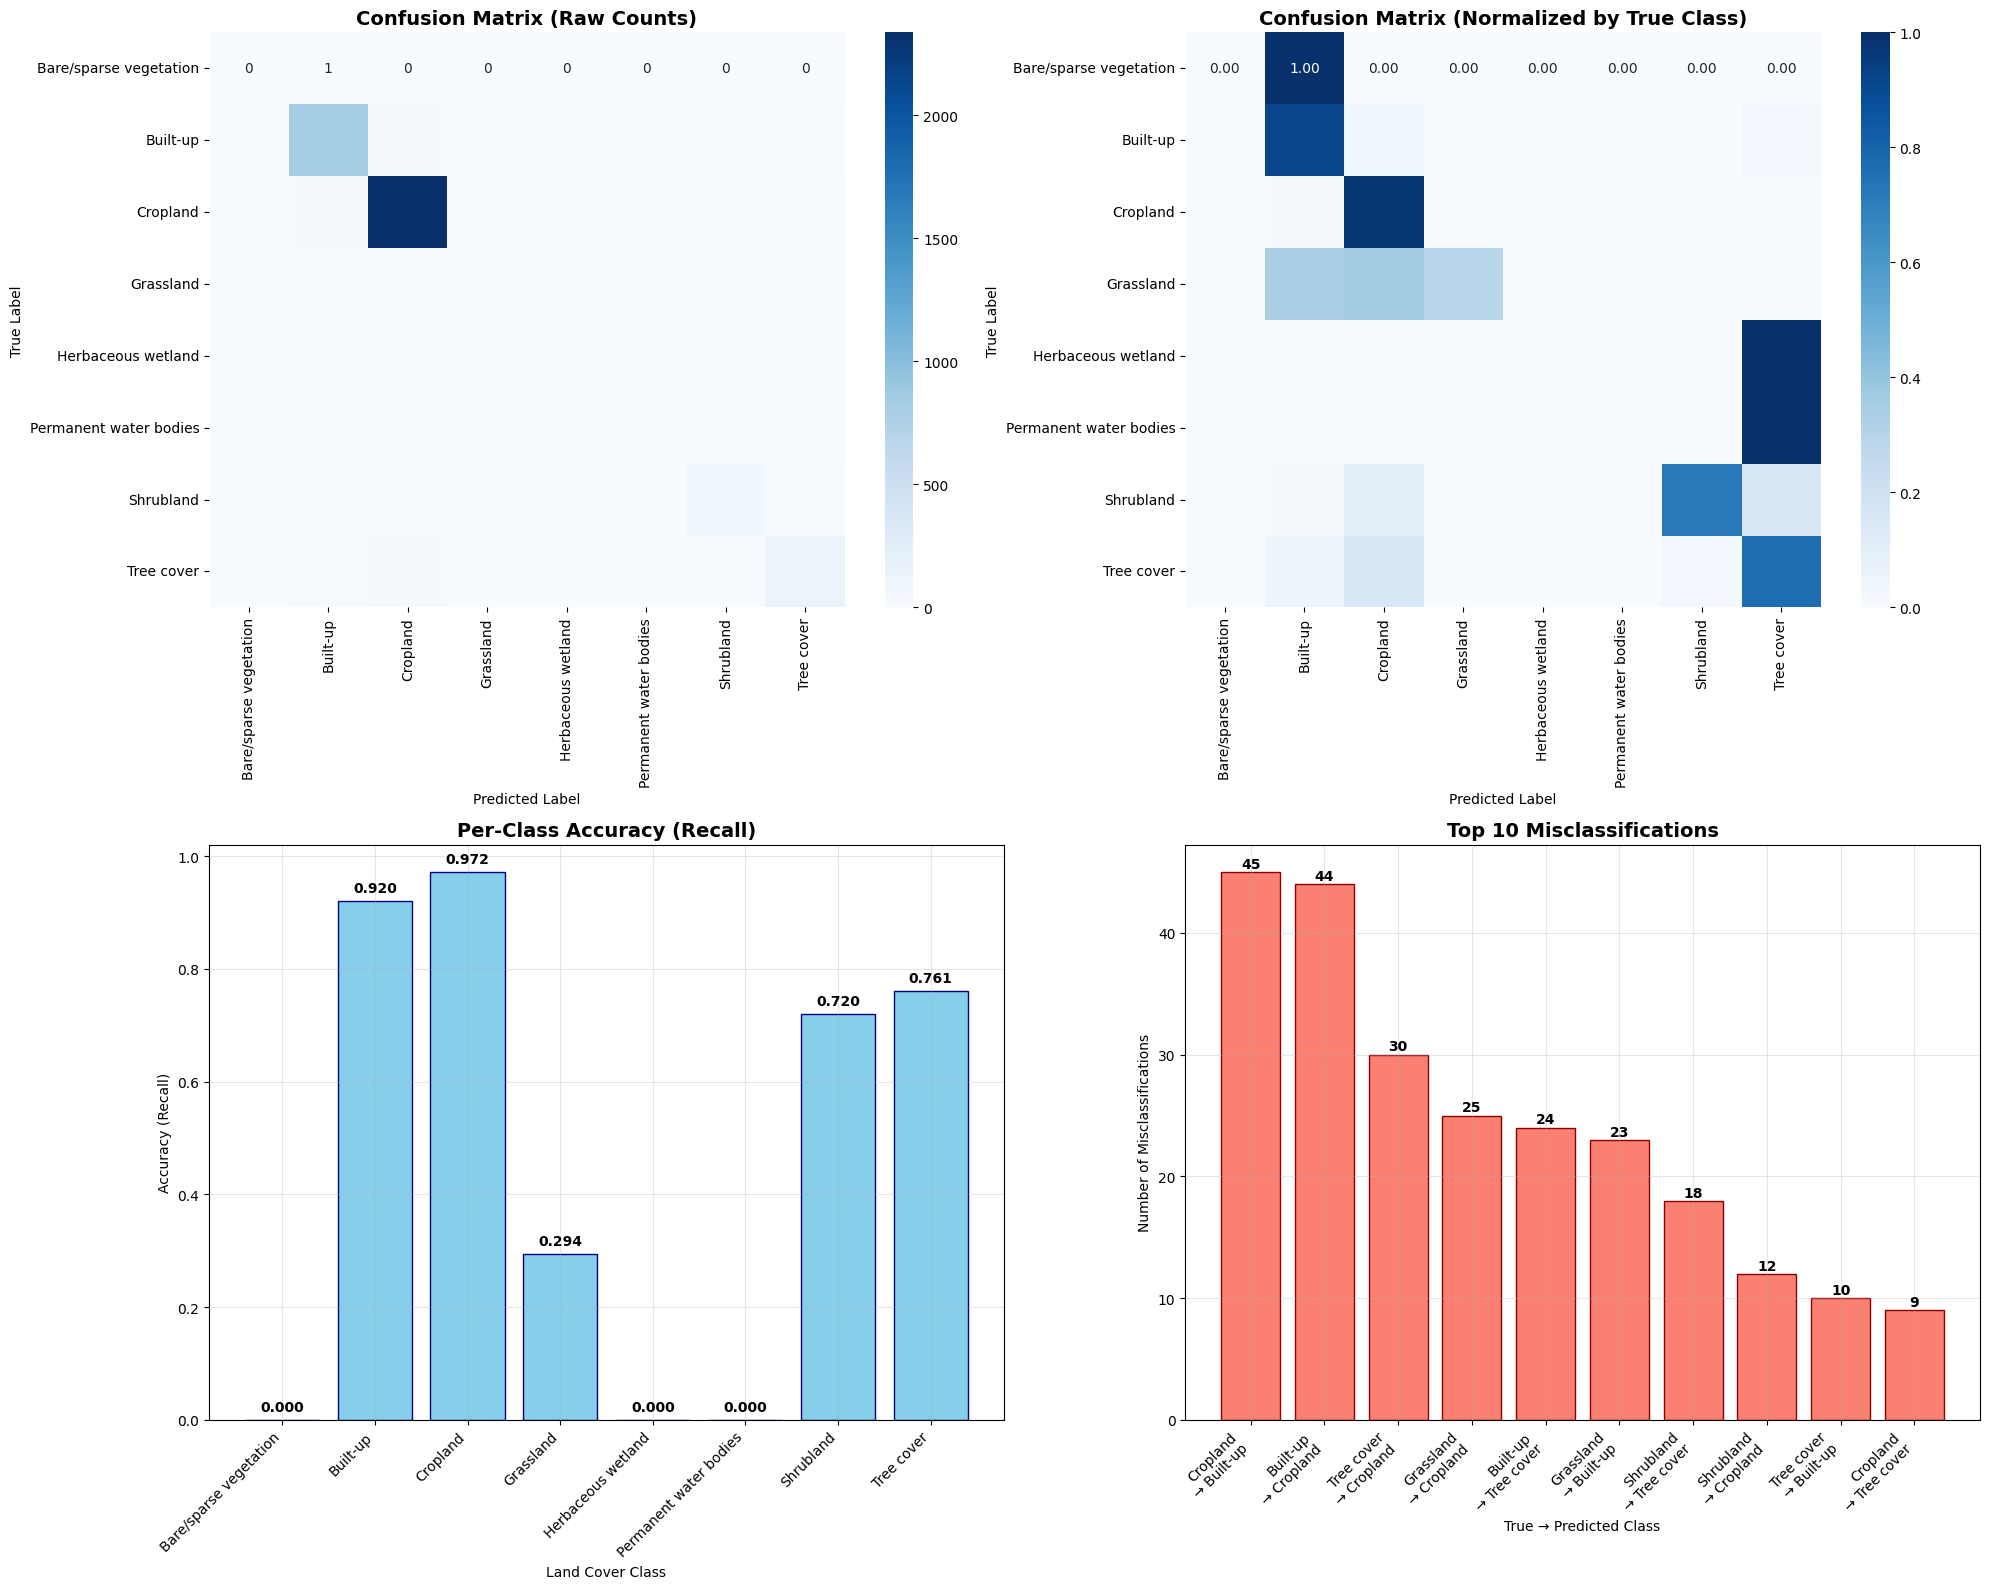


=== Detailed Confusion Matrix Analysis ===
Total predictions: 3687
Correct predictions: 3416 (92.6%)

=== Per-Class Performance ===
Class                Accuracy   Support    Best At         Worst At       
--------------------------------------------------------------------------------
Bare/sparse vegetation 0.000      1          None            Built-up       
Built-up             0.920      904        Cropland        Cropland       
Cropland             0.972      2404       Built-up        Built-up       
Grassland            0.294      68         Cropland        Cropland       
Herbaceous wetland   0.000      1          None            Tree cover     
Permanent water bodies 0.000      3          None            Tree cover     
Shrubland            0.720      118        Cropland        Tree cover     
Tree cover           0.761      188        Built-up        Cropland       

=== Top Misclassification Patterns ===
1. Cropland → Built-up: 45 cases (1.9% of Cropland samples)
2. Buil

In [46]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("=== Confusion Matrix Analysis ===")
print("\nA confusion matrix shows how well the model classifies each class:")
print("- Rows represent TRUE labels (what the image actually contains)")
print("- Columns represent PREDICTED labels (what the model predicted)")
print("- Diagonal elements = correct predictions")
print("- Off-diagonal elements = misclassifications")

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [idx2label[i] for i in range(len(idx2label))]

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Raw counts confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')

# 2. Normalized confusion matrix (by true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix (Normalized by True Class)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Predicted Label')
axes[0,1].set_ylabel('True Label')

# 3. Per-class accuracy visualization
class_accuracies = np.diag(cm) / cm.sum(axis=1)
bars = axes[1,0].bar(range(len(class_names)), class_accuracies, color='skyblue', edgecolor='navy')
axes[1,0].set_title('Per-Class Accuracy (Recall)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Land Cover Class')
axes[1,0].set_ylabel('Accuracy (Recall)')
axes[1,0].set_xticks(range(len(class_names)))
axes[1,0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Most common misclassifications
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i,j] > 0:  # Misclassification
            misclassifications.append({
                'true_class': class_names[i],
                'pred_class': class_names[j],
                'count': cm[i,j],
                'percentage': (cm[i,j] / cm[i].sum()) * 100
            })

# Sort by count and show top misclassifications
misclassifications.sort(key=lambda x: x['count'], reverse=True)
top_mistakes = misclassifications[:10]  # Top 10 mistakes

if top_mistakes:
    mistake_labels = [f"{m['true_class']}\n→ {m['pred_class']}" for m in top_mistakes]
    mistake_counts = [m['count'] for m in top_mistakes]
    
    bars = axes[1,1].bar(range(len(mistake_labels)), mistake_counts, color='salmon', edgecolor='darkred')
    axes[1,1].set_title('Top 10 Misclassifications', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('True → Predicted Class')
    axes[1,1].set_ylabel('Number of Misclassifications')
    axes[1,1].set_xticks(range(len(mistake_labels)))
    axes[1,1].set_xticklabels(mistake_labels, rotation=45, ha='right')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed analysis and interpretation
print(f"\n=== Detailed Confusion Matrix Analysis ===")
print(f"Total predictions: {cm.sum()}")
print(f"Correct predictions: {np.trace(cm)} ({np.trace(cm)/cm.sum()*100:.1f}%)")

print(f"\n=== Per-Class Performance ===")
print(f"{'Class':<20} {'Accuracy':<10} {'Support':<10} {'Best At':<15} {'Worst At':<15}")
print("-" * 80)

for i, class_name in enumerate(class_names):
    # Class accuracy (recall)
    class_accuracy = cm[i,i] / cm[i].sum() if cm[i].sum() > 0 else 0
    support = cm[i].sum()
    
    # Find what this class is most often confused with (excluding correct predictions)
    confusion_row = cm[i].copy()
    confusion_row[i] = 0  # Remove correct predictions
    most_confused_idx = np.argmax(confusion_row) if confusion_row.max() > 0 else i
    most_confused_class = class_names[most_confused_idx] if confusion_row.max() > 0 else "None"
    
    # Find what most often gets predicted as this class (false positives)
    confusion_col = cm[:, i].copy()
    confusion_col[i] = 0  # Remove correct predictions
    most_fp_idx = np.argmax(confusion_col) if confusion_col.max() > 0 else i
    most_fp_class = class_names[most_fp_idx] if confusion_col.max() > 0 else "None"
    
    print(f"{class_name:<20} {class_accuracy:<10.3f} {support:<10} {most_fp_class:<15} {most_confused_class:<15}")

print(f"\n=== Top Misclassification Patterns ===")
if top_mistakes:
    for i, mistake in enumerate(top_mistakes[:5]):
        print(f"{i+1}. {mistake['true_class']} → {mistake['pred_class']}: "
              f"{mistake['count']} cases ({mistake['percentage']:.1f}% of {mistake['true_class']} samples)")

print(f"\n=== Model Interpretation ===")
best_class_idx = np.argmax(np.diag(cm) / cm.sum(axis=1))
worst_class_idx = np.argmin(np.diag(cm) / cm.sum(axis=1))

print(f"✅ Best classified class: {class_names[best_class_idx]} "
      f"({(cm[best_class_idx,best_class_idx] / cm[best_class_idx].sum())*100:.1f}% accuracy)")
print(f"❌ Worst classified class: {class_names[worst_class_idx]} "
      f"({(cm[worst_class_idx,worst_class_idx] / cm[worst_class_idx].sum())*100:.1f}% accuracy)")

# Class imbalance analysis
class_distribution = cm.sum(axis=1)
most_common_idx = np.argmax(class_distribution)
least_common_idx = np.argmin(class_distribution)

print(f"\n📊 Class Distribution Analysis:")
print(f"Most common class: {class_names[most_common_idx]} ({class_distribution[most_common_idx]} samples)")
print(f"Least common class: {class_names[least_common_idx]} ({class_distribution[least_common_idx]} samples)")
print(f"Imbalance ratio: {class_distribution[most_common_idx]/class_distribution[least_common_idx]:.1f}:1")

if class_distribution[most_common_idx]/class_distribution[least_common_idx] > 5:
    print("⚠️  Significant class imbalance detected! Consider class weighting or resampling.")
else:
    print("✅ Reasonable class balance.")

=== Visualizing Model Predictions ===
Collected 3687 detailed predictions
Correct predictions: 3416
Incorrect predictions: 271

Plotting 5 most confident correct predictions...
Collected 3687 detailed predictions
Correct predictions: 3416
Incorrect predictions: 271

Plotting 5 most confident correct predictions...


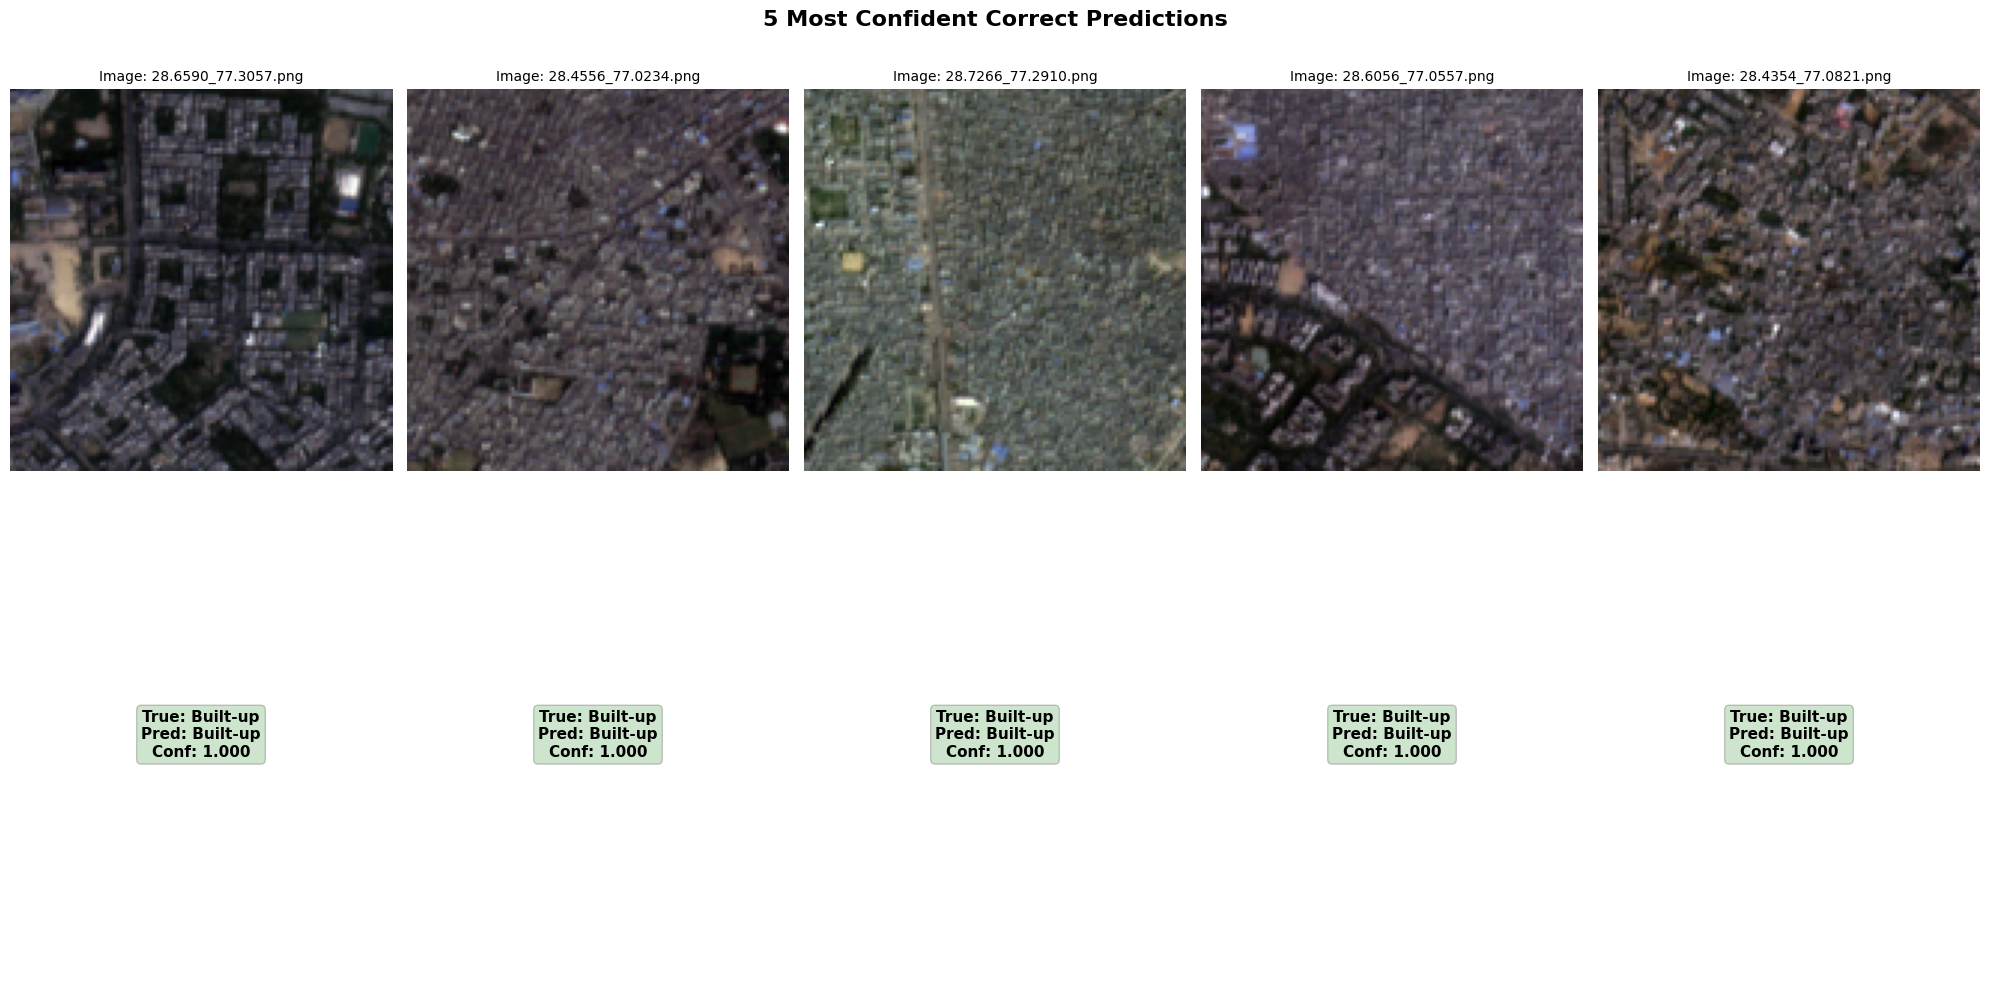


Plotting 5 most confident incorrect predictions...


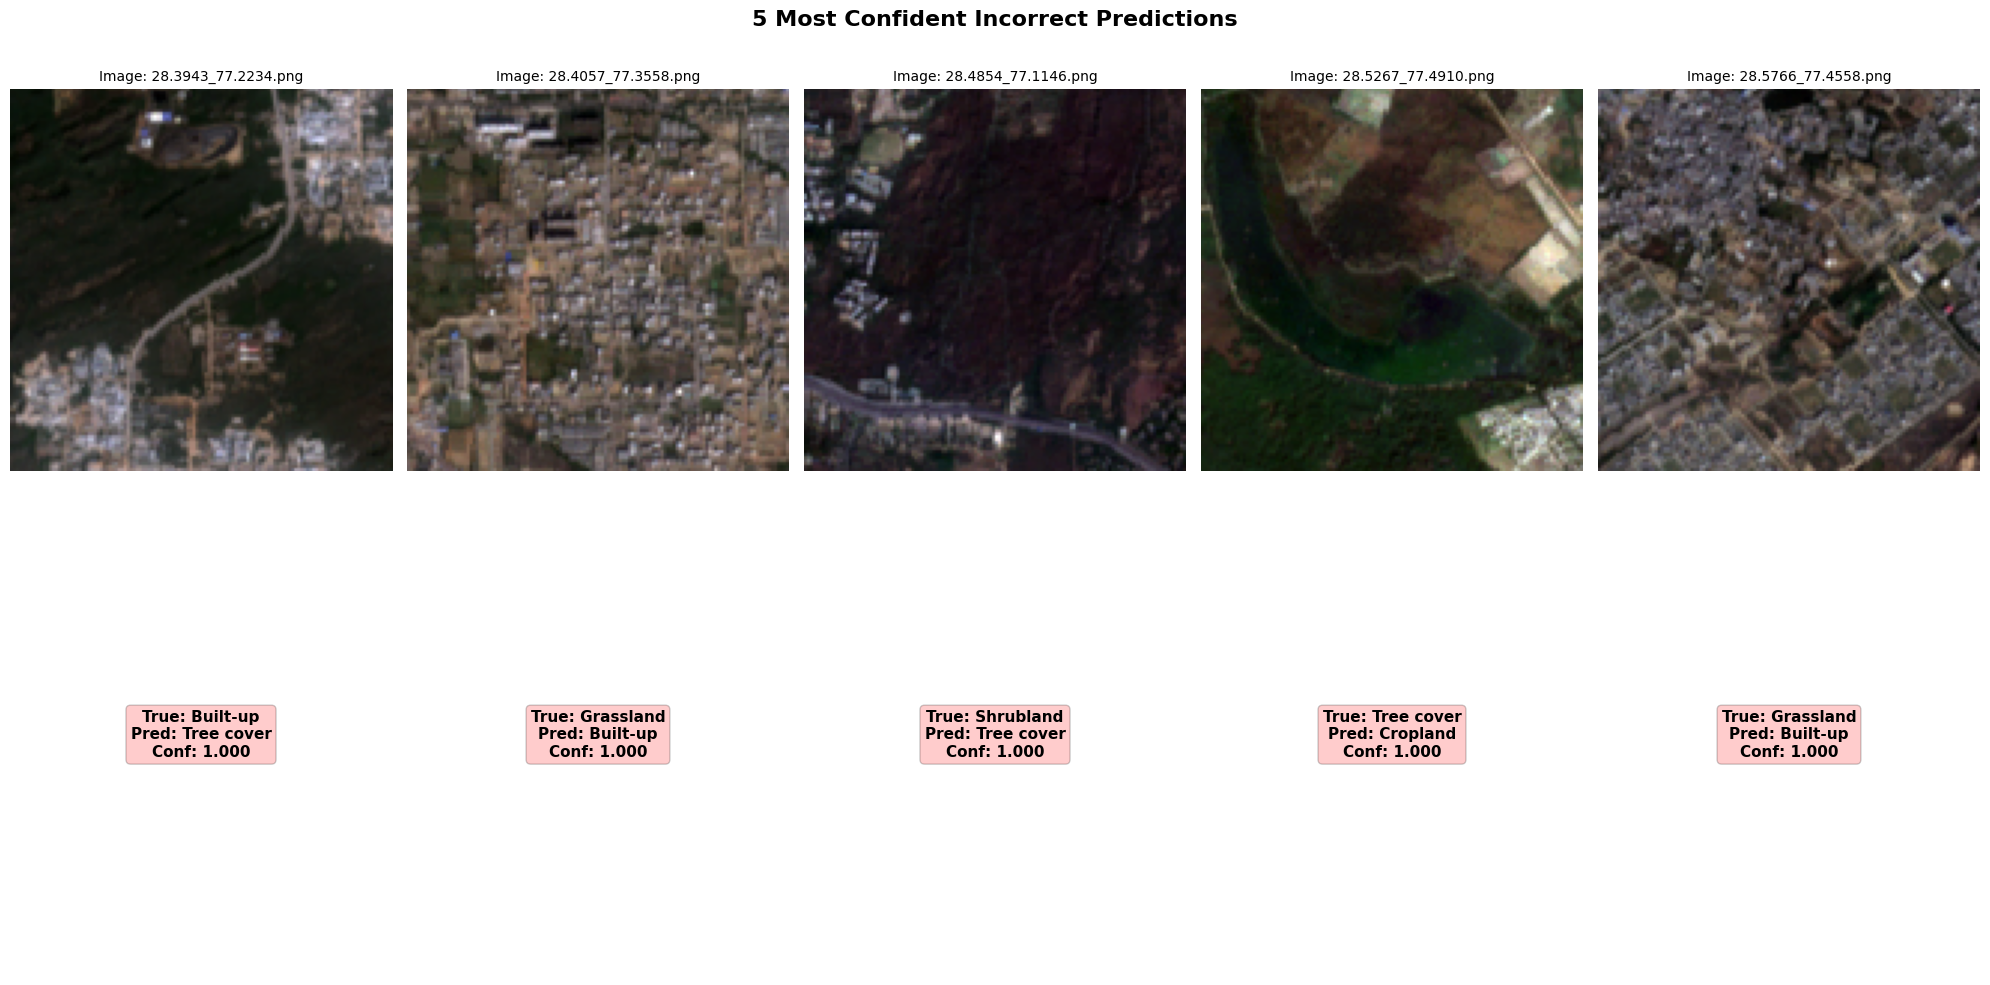


=== Analysis of Selected Predictions ===

📍 Correct Predictions Analysis:
1. 28.6590_77.3057.png: Built-up (confidence: 1.000)
2. 28.4556_77.0234.png: Built-up (confidence: 1.000)
3. 28.7266_77.2910.png: Built-up (confidence: 1.000)
4. 28.6056_77.0557.png: Built-up (confidence: 1.000)
5. 28.4354_77.0821.png: Built-up (confidence: 1.000)

❌ Incorrect Predictions Analysis:
1. 28.3943_77.2234.png: Built-up → Tree cover (confidence: 1.000)
2. 28.4057_77.3558.png: Grassland → Built-up (confidence: 1.000)
3. 28.4854_77.1146.png: Shrubland → Tree cover (confidence: 1.000)
4. 28.5267_77.4910.png: Tree cover → Cropland (confidence: 1.000)
5. 28.5766_77.4558.png: Grassland → Built-up (confidence: 1.000)

📊 Confidence Statistics:
Overall mean confidence: 0.962 ± 0.100
Correct predictions mean confidence: 0.975 ± 0.078
Incorrect predictions mean confidence: 0.801 ± 0.179


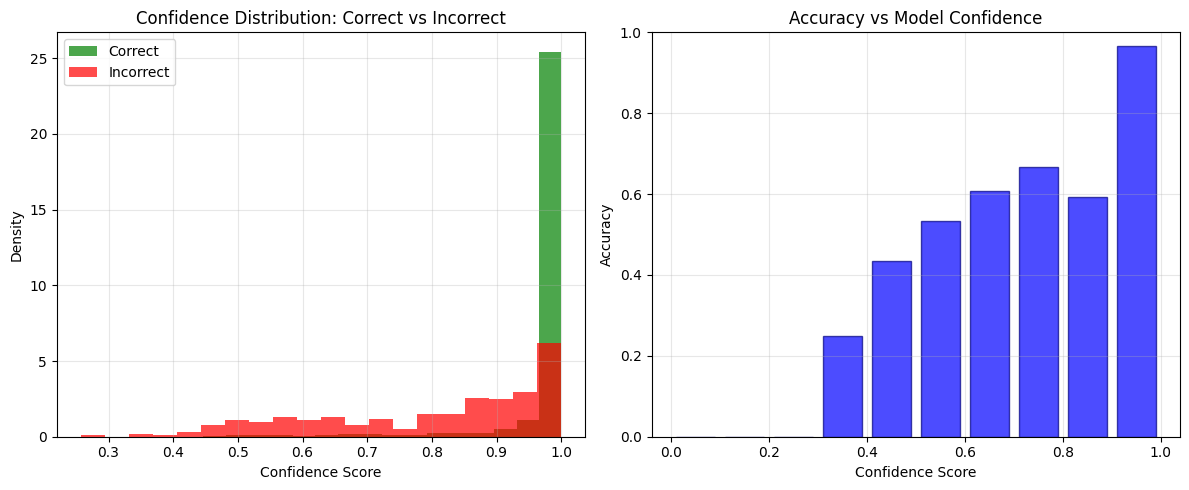


💡 Key Insights:
• Model is generally well-calibrated
• High confidence incorrect predictions suggest potential systematic errors
• Visual inspection can reveal data quality issues or annotation errors


In [47]:

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print("=== Visualizing Model Predictions ===")

# Get detailed predictions with filenames for visualization
model.eval()
detailed_predictions = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Get softmax probabilities for confidence
        probs = torch.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probs, dim=1)
        
        # Store detailed info for each prediction
        batch_start_idx = batch_idx * test_loader.batch_size
        for i in range(len(preds)):
            global_idx = batch_start_idx + i
            if global_idx < len(test_df):
                filename = test_df.iloc[global_idx]['filename']
                true_label = labels[i].item()
                pred_label = preds[i].item()
                confidence = max_probs[i].item()
                
                detailed_predictions.append({
                    'filename': filename,
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'confidence': confidence,
                    'correct': true_label == pred_label
                })

print(f"Collected {len(detailed_predictions)} detailed predictions")

# Separate correct and incorrect predictions
correct_preds = [p for p in detailed_predictions if p['correct']]
incorrect_preds = [p for p in detailed_predictions if not p['correct']]

print(f"Correct predictions: {len(correct_preds)}")
print(f"Incorrect predictions: {len(incorrect_preds)}")

# Sort by confidence to get most confident correct/incorrect predictions
correct_preds.sort(key=lambda x: x['confidence'], reverse=True)
incorrect_preds.sort(key=lambda x: x['confidence'], reverse=True)

# Select 5 of each type
selected_correct = correct_preds[:5]
selected_incorrect = incorrect_preds[:5]

def plot_predictions(predictions, title, fig_size=(20, 10)):
    """Plot predictions with images and labels"""
    if not predictions:
        print(f"No {title.lower()} available to plot")
        return
    
    n_plots = len(predictions)
    fig, axes = plt.subplots(2, n_plots, figsize=fig_size)
    if n_plots == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, pred in enumerate(predictions):
        try:
            # Load and display image
            img_path = os.path.join(rgb_dir, pred['filename'])
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[0, i].imshow(img)
                axes[0, i].set_title(f"Image: {pred['filename']}", fontsize=10)
                axes[0, i].axis('off')
                
                # Add prediction information
                true_class = idx2label[pred['true_label']]
                pred_class = idx2label[pred['pred_label']]
                confidence = pred['confidence']
                
                info_text = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}"
                
                # Color code: green for correct, red for incorrect
                color = 'green' if pred['correct'] else 'red'
                axes[1, i].text(0.5, 0.5, info_text, 
                               transform=axes[1, i].transAxes,
                               fontsize=11, fontweight='bold',
                               ha='center', va='center',
                               bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.2))
                axes[1, i].set_xlim(0, 1)
                axes[1, i].set_ylim(0, 1)
                axes[1, i].axis('off')
            else:
                axes[0, i].text(0.5, 0.5, f"Image not found:\n{pred['filename']}", 
                               ha='center', va='center', transform=axes[0, i].transAxes)
                axes[0, i].axis('off')
                axes[1, i].axis('off')
                
        except Exception as e:
            print(f"Error plotting {pred['filename']}: {e}")
            axes[0, i].text(0.5, 0.5, f"Error loading\n{pred['filename']}", 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    return fig

# Plot correct predictions
print("\nPlotting 5 most confident correct predictions...")
fig_correct = plot_predictions(selected_correct, "5 Most Confident Correct Predictions")
if fig_correct:
    plt.savefig('correct_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot incorrect predictions  
print("\nPlotting 5 most confident incorrect predictions...")
fig_incorrect = plot_predictions(selected_incorrect, "5 Most Confident Incorrect Predictions")
if fig_incorrect:
    plt.savefig('incorrect_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Additional analysis of the selected predictions
print("\n=== Analysis of Selected Predictions ===")

print("\n📍 Correct Predictions Analysis:")
for i, pred in enumerate(selected_correct):
    true_class = idx2label[pred['true_label']]
    print(f"{i+1}. {pred['filename']}: {true_class} (confidence: {pred['confidence']:.3f})")

print("\n❌ Incorrect Predictions Analysis:")
for i, pred in enumerate(selected_incorrect):
    true_class = idx2label[pred['true_label']]
    pred_class = idx2label[pred['pred_label']]
    print(f"{i+1}. {pred['filename']}: {true_class} → {pred_class} (confidence: {pred['confidence']:.3f})")

# Confidence analysis
all_confidences = [p['confidence'] for p in detailed_predictions]
correct_confidences = [p['confidence'] for p in correct_preds]
incorrect_confidences = [p['confidence'] for p in incorrect_preds]

print(f"\n📊 Confidence Statistics:")
print(f"Overall mean confidence: {np.mean(all_confidences):.3f} ± {np.std(all_confidences):.3f}")
print(f"Correct predictions mean confidence: {np.mean(correct_confidences):.3f} ± {np.std(correct_confidences):.3f}")
print(f"Incorrect predictions mean confidence: {np.mean(incorrect_confidences):.3f} ± {np.std(incorrect_confidences):.3f}")

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='green', density=True)
plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='red', density=True)
plt.xlabel('Confidence Score')
plt.ylabel('Density')
plt.title('Confidence Distribution: Correct vs Incorrect')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
confidence_bins = np.linspace(0, 1, 11)
correct_counts, _ = np.histogram(correct_confidences, bins=confidence_bins)
incorrect_counts, _ = np.histogram(incorrect_confidences, bins=confidence_bins)
total_counts = correct_counts + incorrect_counts

# Calculate accuracy per confidence bin
accuracy_per_bin = np.divide(correct_counts, total_counts, 
                            out=np.zeros_like(correct_counts, dtype=float), 
                            where=total_counts!=0)

bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
plt.bar(bin_centers, accuracy_per_bin, width=0.08, alpha=0.7, color='blue', edgecolor='navy')
plt.xlabel('Confidence Score')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Model Confidence')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💡 Key Insights:")
print(f"• Model is generally {'well-calibrated' if np.mean(correct_confidences) > np.mean(incorrect_confidences) else 'poorly-calibrated'}")
print(f"• High confidence incorrect predictions suggest potential systematic errors")
print(f"• Visual inspection can reveal data quality issues or annotation errors")